## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("../day_month.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,8.075,143.0,210.0,1.72,218.0,94.6,0.434,4.063830,6.50,61.673648,...,95.675,1025.209907,1023.175,1027.325,210.491356,114.25,281.5,3.281959,1.625,5.025
1,0.700,143.0,210.0,1.72,218.0,94.6,0.434,4.221410,5.00,61.055629,...,95.350,1029.553147,1027.750,1031.600,221.406250,115.00,273.0,3.476042,1.650,5.000
2,1.325,143.0,210.0,1.72,218.0,94.6,0.434,6.932292,8.75,89.687500,...,92.875,1004.979167,1002.000,1009.450,202.578125,153.50,255.0,6.997396,5.025,9.425
3,1.300,143.0,210.0,1.72,218.0,94.6,0.434,5.822917,7.50,89.614583,...,92.700,1004.126042,1000.750,1010.600,216.354167,181.50,259.0,7.590625,5.450,9.650
4,18.250,143.0,210.0,1.72,218.0,94.6,0.434,6.647368,11.50,154.226316,...,85.625,1019.062632,1016.375,1021.425,154.531579,123.00,190.0,5.128947,3.625,7.500


In [2]:
df.shape

(6586, 34)

## Preoaring the (x,y) pairs

### Scaling the data

In [3]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [4]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [5]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [6]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((6562, 24, 34), (6562,))

### Splitting the data

In [7]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((5268, 24, 34), (5268,), (659, 24, 34), (659,), (635, 24, 34), (635,))

### Plotting the splits

In [8]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

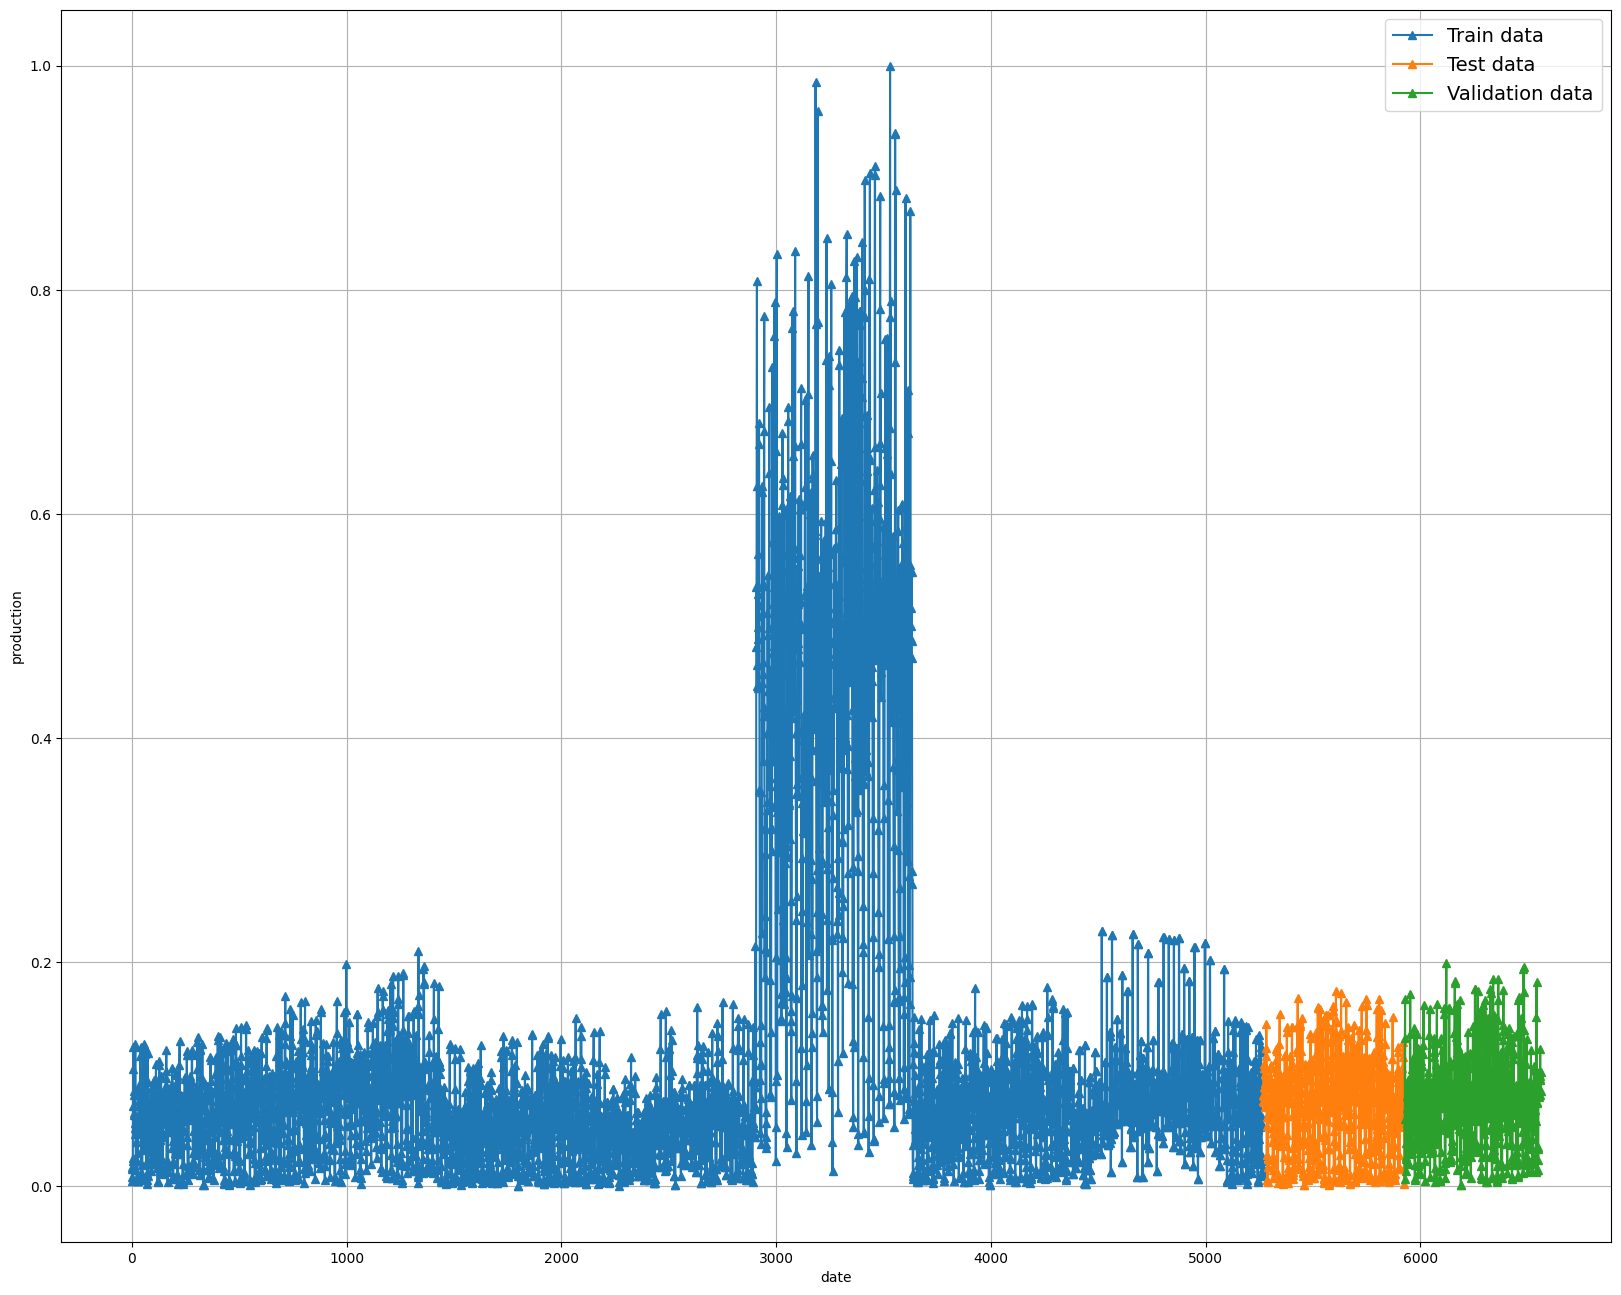

In [9]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [10]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [11]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [12]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [13]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [14]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [15]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [16]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [17]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(5268, 24, 34) -> (5268, 24, 1, 34)


In [18]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=64, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=64, kernel_size=(1,),
               activation='tanh', return_sequences=False),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

conv_lstm_model.summary()

C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 64)           │          25,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,593 (244.50 KB)

 Trainable params: 62,593 (244.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [19]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 21:55:10] [setup] RAM Tracking...
[codecarbon INFO @ 21:55:10] [setup] CPU Tracking...
[codecarbon WARNING @ 21:55:10] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 21:55:11] We saw that you have a AMD Ryzen 7 7840HS w/ Radeon 780M Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 21:55:11] CPU Model on constant consumption mode: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics
[codecarbon INFO @ 21:55:11] [setup] GPU Tracking...
[codecarbon INFO @ 21:55:11] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 21:55:11] >>> Tracker's metadata:
[codecarbon INFO @ 21:55:11]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:55:11]   Python version: 3.12.3
[codecarbon INFO @ 21:55:11]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 21:55:11]   Available RAM : 15.288 GB
[codecarbon INFO @ 21:55:11]   CPU count: 16
[codecarbon INFO @ 21:

In [20]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [21]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.1244 - val_loss: 0.0338
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0575 - val_loss: 0.0374
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0493 - val_loss: 0.0344
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0463 - val_loss: 0.0325
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0451 - val_loss: 0.0315
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0444 - val_loss: 0.0305
Epoch 7/300
 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0439 

[codecarbon INFO @ 21:55:22] Energy consumed for RAM : 0.000016 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:55:22] Energy consumed for all CPUs : 0.000119 kWh. Total CPU Power : 42.5 W


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0439

[codecarbon INFO @ 21:55:22] Energy consumed for all GPUs : 0.000013 kWh. Total GPU Power : 4.6482380007174395 W
[codecarbon INFO @ 21:55:22] 0.000148 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0438 - val_loss: 0.0303
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0435 - val_loss: 0.0298
Epoch 9/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0430 - val_loss: 0.0294
Epoch 10/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0425 - val_loss: 0.0289
Epoch 11/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0418 - val_loss: 0.0288
Epoch 12/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0410 - val_loss: 0.0286
Epoch 13/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0404 - val_loss: 0.0302
Epoch 14/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0396 - val_loss: 0.0289
Epoch 15/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0389 - val_loss: 0.0279
Epoch 16/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0381 - val_loss: 0.0276
Epoch 17/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0372 - val_loss: 0.0274
Epoch 18/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - los

[codecarbon INFO @ 21:55:32] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:55:32] Energy consumed for all CPUs : 0.000237 kWh. Total CPU Power : 42.5 W


 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0367

[codecarbon INFO @ 21:55:32] Energy consumed for all GPUs : 0.000023 kWh. Total GPU Power : 3.486294141872807 W
[codecarbon INFO @ 21:55:32] 0.000291 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0370 - val_loss: 0.0271
Epoch 21/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0361 - val_loss: 0.0260
Epoch 22/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0365 - val_loss: 0.0276
Epoch 23/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0357 - val_loss: 0.0263
Epoch 24/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0359 - val_loss: 0.0272
Epoch 25/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0354 - val_loss: 0.0260
Epoch 26/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0355 - val_loss: 0.0258
Epoch 27/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0351 - val_loss: 0.0256
Epoch 28/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0358 - val_loss: 0.0265
Epoch 29/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0353 - val_loss: 0.0275
Epoch 30/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0348 - val_loss: 0.0276
Epoch 31/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - l

[codecarbon INFO @ 21:55:42] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:55:42] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W


 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0350

[codecarbon INFO @ 21:55:42] Energy consumed for all GPUs : 0.000047 kWh. Total GPU Power : 8.564845510609384 W
[codecarbon INFO @ 21:55:42] 0.000449 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0350 - val_loss: 0.0259
Epoch 34/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0353 - val_loss: 0.0256
Epoch 35/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0356 - val_loss: 0.0291
Epoch 36/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0350 - val_loss: 0.0256
Epoch 37/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0340 - val_loss: 0.0260
Epoch 38/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0344 - val_loss: 0.0265
Epoch 39/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0348 - val_loss: 0.0260
Epoch 40/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0339 - val_loss: 0.0258
Epoch 41/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0338 - val_loss: 0.0256
Epoch 42/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0344 - val_loss: 0.0254
Epoch 43/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0347 - val_loss: 0.0254
Epoch 44/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - l

[codecarbon INFO @ 21:55:52] Energy consumed for RAM : 0.000064 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:55:52] Energy consumed for all CPUs : 0.000473 kWh. Total CPU Power : 42.5 W


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0338

[codecarbon INFO @ 21:55:52] Energy consumed for all GPUs : 0.000060 kWh. Total GPU Power : 4.752094193429478 W
[codecarbon INFO @ 21:55:52] 0.000596 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0337 - val_loss: 0.0254
Epoch 47/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0334 - val_loss: 0.0252
Epoch 48/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0340 - val_loss: 0.0250
Epoch 49/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0340 - val_loss: 0.0253
Epoch 50/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0340 - val_loss: 0.0270
Epoch 51/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0337 - val_loss: 0.0269
Epoch 52/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0332 - val_loss: 0.0259
Epoch 53/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0332 - val_loss: 0.0250
Epoch 54/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0335 - val_loss: 0.0250
Epoch 55/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0332 - val_loss: 0.0248
Epoch 56/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0335 - val_loss: 0.0248
Epoch 57/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - l

[codecarbon INFO @ 21:56:02] Energy consumed for RAM : 0.000079 kWh. RAM Power : 5.732982158660889 W


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0341

[codecarbon INFO @ 21:56:02] Energy consumed for all CPUs : 0.000591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:02] Energy consumed for all GPUs : 0.000069 kWh. Total GPU Power : 3.380535572501582 W
[codecarbon INFO @ 21:56:02] 0.000739 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0340 - val_loss: 0.0263
Epoch 60/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0348 - val_loss: 0.0307
Epoch 61/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0353 - val_loss: 0.0252
Epoch 62/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0344 - val_loss: 0.0271
Epoch 63/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0339 - val_loss: 0.0260
Epoch 64/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0333 - val_loss: 0.0266
Epoch 65/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0336 - val_loss: 0.0267
Epoch 66/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0336 - val_loss: 0.0275
Epoch 67/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0332 - val_loss: 0.0254
Epoch 68/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0325 - val_loss: 0.0251
Epoch 69/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0328 - val_loss: 0.0247
Epoch 70/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - l

[codecarbon INFO @ 21:56:12] Energy consumed for RAM : 0.000095 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:56:12] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W


 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0325

[codecarbon INFO @ 21:56:12] Energy consumed for all GPUs : 0.000079 kWh. Total GPU Power : 3.4928374430455316 W
[codecarbon INFO @ 21:56:12] 0.000883 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0323 - val_loss: 0.0249
Epoch 74/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0328 - val_loss: 0.0246
Epoch 75/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0326 - val_loss: 0.0254
Epoch 76/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0326 - val_loss: 0.0247
Epoch 77/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0321 - val_loss: 0.0246
Epoch 78/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0322 - val_loss: 0.0260
Epoch 79/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0327 - val_loss: 0.0255
Epoch 80/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0323 - val_loss: 0.0243
Epoch 81/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0315 - val_loss: 0.0242
Epoch 82/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0312 - val_loss: 0.0242
Epoch 83/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0313 - val_loss: 0.0250
Epoch 84/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - l

[codecarbon INFO @ 21:56:22] Energy consumed for RAM : 0.000111 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:56:22] Energy consumed for all CPUs : 0.000827 kWh. Total CPU Power : 42.5 W


 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0309

[codecarbon INFO @ 21:56:22] Energy consumed for all GPUs : 0.000089 kWh. Total GPU Power : 3.7303402185953423 W
[codecarbon INFO @ 21:56:22] 0.001028 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0312 - val_loss: 0.0247
Epoch 87/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0306 - val_loss: 0.0246
Epoch 88/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0312 - val_loss: 0.0242
Epoch 89/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0310 - val_loss: 0.0244
Epoch 90/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0319 - val_loss: 0.0241
Epoch 91/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0315 - val_loss: 0.0249
Epoch 92/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0311 - val_loss: 0.0237
Epoch 93/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0315 - val_loss: 0.0254
Epoch 94/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0310 - val_loss: 0.0245
Epoch 95/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0306 - val_loss: 0.0234
Epoch 96/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0308 - val_loss: 0.0249
Epoch 97/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - l

[codecarbon INFO @ 21:56:32] Energy consumed for RAM : 0.000127 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:56:32] Energy consumed for all CPUs : 0.000945 kWh. Total CPU Power : 42.5 W


 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0294

[codecarbon INFO @ 21:56:32] Energy consumed for all GPUs : 0.000108 kWh. Total GPU Power : 6.876362856124693 W
[codecarbon INFO @ 21:56:32] 0.001181 kWh of electricity used since the beginning.


 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0296

[codecarbon INFO @ 21:56:32] 0.000265 g.CO2eq/s mean an estimation of 8.365536854727933 kg.CO2eq/year


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0296 - val_loss: 0.0237
Epoch 100/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0301 - val_loss: 0.0248
Epoch 101/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0306 - val_loss: 0.0233
Epoch 102/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0299 - val_loss: 0.0236
Epoch 103/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0297 - val_loss: 0.0232
Epoch 104/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0297 - val_loss: 0.0233
Epoch 105/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0292 - val_loss: 0.0231
Epoch 106/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0292 - val_loss: 0.0228
Epoch 107/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0288 - val_loss: 0.0255
Epoch 108/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0300 - val_loss: 0.0227
Epoch 109/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0284 - val_loss: 0.0240
Epoch 110/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68

[codecarbon INFO @ 21:56:42] Energy consumed for RAM : 0.000143 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:56:42] Energy consumed for all CPUs : 0.001064 kWh. Total CPU Power : 42.5 W


 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0301

[codecarbon INFO @ 21:56:42] Energy consumed for all GPUs : 0.000131 kWh. Total GPU Power : 8.1293879990099 W
[codecarbon INFO @ 21:56:42] 0.001337 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0299 - val_loss: 0.0233
Epoch 113/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0289 - val_loss: 0.0222
Epoch 114/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0290 - val_loss: 0.0232
Epoch 115/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0286 - val_loss: 0.0226
Epoch 116/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0284 - val_loss: 0.0232
Epoch 117/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0283 - val_loss: 0.0225
Epoch 118/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0290 - val_loss: 0.0228
Epoch 119/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0286 - val_loss: 0.0227
Epoch 120/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0284 - val_loss: 0.0229
Epoch 121/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0282 - val_loss: 0.0235
Epoch 122/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0288 - val_loss: 0.0233
Epoch 123/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65

[codecarbon INFO @ 21:56:52] Energy consumed for RAM : 0.000159 kWh. RAM Power : 5.732982158660889 W


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0284

[codecarbon INFO @ 21:56:52] Energy consumed for all CPUs : 0.001181 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:52] Energy consumed for all GPUs : 0.000155 kWh. Total GPU Power : 8.728592105601484 W
[codecarbon INFO @ 21:56:52] 0.001495 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0283 - val_loss: 0.0228
Epoch 126/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0287 - val_loss: 0.0238
Epoch 127/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0293 - val_loss: 0.0214
Epoch 128/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0288 - val_loss: 0.0225
Epoch 129/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0282 - val_loss: 0.0244
Epoch 130/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0283 - val_loss: 0.0213
Epoch 131/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0281 - val_loss: 0.0214
Epoch 132/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0281 - val_loss: 0.0215
Epoch 133/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0275 - val_loss: 0.0213
Epoch 134/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0285 - val_loss: 0.0212
Epoch 135/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0281 - val_loss: 0.0217
Epoch 136/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71

[codecarbon INFO @ 21:57:02] Energy consumed for RAM : 0.000175 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:57:02] Energy consumed for all CPUs : 0.001300 kWh. Total CPU Power : 42.5 W


 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0282

[codecarbon INFO @ 21:57:02] Energy consumed for all GPUs : 0.000179 kWh. Total GPU Power : 8.687923617524211 W
[codecarbon INFO @ 21:57:02] 0.001653 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0282 - val_loss: 0.0219
Epoch 138/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0275 - val_loss: 0.0217
Epoch 139/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0279 - val_loss: 0.0214
Epoch 140/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0272 - val_loss: 0.0207
Epoch 141/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0276 - val_loss: 0.0209
Epoch 142/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0277 - val_loss: 0.0209
Epoch 143/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0272 - val_loss: 0.0211
Epoch 144/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0275 - val_loss: 0.0205
Epoch 145/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0282 - val_loss: 0.0215
Epoch 146/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0280 - val_loss: 0.0214
Epoch 147/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0276 - val_loss: 0.0221
Epoch 148/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68

[codecarbon INFO @ 21:57:12] Energy consumed for RAM : 0.000190 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:57:12] Energy consumed for all CPUs : 0.001418 kWh. Total CPU Power : 42.5 W


 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0275

[codecarbon INFO @ 21:57:12] Energy consumed for all GPUs : 0.000189 kWh. Total GPU Power : 3.4797471889840916 W
[codecarbon INFO @ 21:57:12] 0.001797 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0277 - val_loss: 0.0207
Epoch 151/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0277 - val_loss: 0.0214
Epoch 152/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0283 - val_loss: 0.0211
Epoch 153/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0293 - val_loss: 0.0208
Epoch 154/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0280 - val_loss: 0.0214
Epoch 155/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0280 - val_loss: 0.0210
Epoch 156/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0278 - val_loss: 0.0210
Epoch 157/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0270 - val_loss: 0.0207
Epoch 158/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0271 - val_loss: 0.0210
Epoch 159/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0271 - val_loss: 0.0205
Epoch 160/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0273 - val_loss: 0.0216
Epoch 161/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75

[codecarbon INFO @ 21:57:22] Energy consumed for RAM : 0.000206 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:57:22] Energy consumed for all CPUs : 0.001536 kWh. Total CPU Power : 42.5 W


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0269

[codecarbon INFO @ 21:57:22] Energy consumed for all GPUs : 0.000205 kWh. Total GPU Power : 5.828935080816414 W
[codecarbon INFO @ 21:57:22] 0.001947 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0268 - val_loss: 0.0209
Epoch 163/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0264 - val_loss: 0.0206
Epoch 164/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0261 - val_loss: 0.0226
Epoch 165/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0268 - val_loss: 0.0214
Epoch 166/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0265 - val_loss: 0.0215
Epoch 167/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0259 - val_loss: 0.0210
Epoch 168/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0262 - val_loss: 0.0217
Epoch 169/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0265 - val_loss: 0.0204
Epoch 170/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0257 - val_loss: 0.0209
Epoch 171/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0264 - val_loss: 0.0206
Epoch 172/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0257 - val_loss: 0.0216
Epoch 173/300
 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s

[codecarbon INFO @ 21:57:32] Energy consumed for RAM : 0.000222 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:57:32] Energy consumed for all CPUs : 0.001654 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:32] Energy consumed for all GPUs : 0.000221 kWh. Total GPU Power : 5.56628450796584 W
[codecarbon INFO @ 21:57:32] 0.002097 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0256 - val_loss: 0.0203
Epoch 174/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0250 - val_loss: 0.0201
Epoch 175/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0249 - val_loss: 0.0200
Epoch 176/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0246 - val_loss: 0.0208
Epoch 177/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0251 - val_loss: 0.0202
Epoch 178/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0245 - val_loss: 0.0209
Epoch 179/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0248 - val_loss: 0.0206
Epoch 180/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0249 - val_loss: 0.0210
Epoch 181/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0247 - val_loss: 0.0215
Epoch 182/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0249 - val_loss: 0.0199
Epoch 183/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0247 - val_loss: 0.0224
Epoch 184/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65

[codecarbon INFO @ 21:57:42] Energy consumed for RAM : 0.000238 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:57:42] Energy consumed for all CPUs : 0.001772 kWh. Total CPU Power : 42.5 W


 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0242

[codecarbon INFO @ 21:57:42] Energy consumed for all GPUs : 0.000237 kWh. Total GPU Power : 6.047241616070945 W
[codecarbon INFO @ 21:57:42] 0.002248 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0242 - val_loss: 0.0199
Epoch 187/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0244 - val_loss: 0.0217
Epoch 188/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0251 - val_loss: 0.0209
Epoch 189/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0253 - val_loss: 0.0212
Epoch 190/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0249 - val_loss: 0.0198
Epoch 191/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0242 - val_loss: 0.0201
Epoch 192/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0236 - val_loss: 0.0201
Epoch 193/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0239 - val_loss: 0.0202
Epoch 194/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0238 - val_loss: 0.0201
Epoch 195/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0240 - val_loss: 0.0217
Epoch 196/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0248 - val_loss: 0.0212
Epoch 197/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68

[codecarbon INFO @ 21:57:52] Energy consumed for RAM : 0.000254 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:57:52] Energy consumed for all CPUs : 0.001890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:52] Energy consumed for all GPUs : 0.000255 kWh. Total GPU Power : 6.512489953029 W
[codecarbon INFO @ 21:57:52] 0.002399 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0240 - val_loss: 0.0198
Epoch 200/300
 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0233

[codecarbon INFO @ 21:57:52] 0.000274 g.CO2eq/s mean an estimation of 8.641132568322973 kg.CO2eq/year


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0239 - val_loss: 0.0198
Epoch 201/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0245 - val_loss: 0.0198
Epoch 202/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0242 - val_loss: 0.0223
Epoch 203/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0247 - val_loss: 0.0201
Epoch 204/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0234 - val_loss: 0.0206
Epoch 205/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0234 - val_loss: 0.0200
Epoch 206/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0227 - val_loss: 0.0212
Epoch 207/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0232 - val_loss: 0.0219
Epoch 208/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0234 - val_loss: 0.0190
Epoch 209/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0235 - val_loss: 0.0203
Epoch 210/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0232 - val_loss: 0.0203
Epoch 211/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70

[codecarbon INFO @ 21:58:02] Energy consumed for RAM : 0.000270 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:58:02] Energy consumed for all CPUs : 0.002008 kWh. Total CPU Power : 42.5 W


 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0223

[codecarbon INFO @ 21:58:02] Energy consumed for all GPUs : 0.000273 kWh. Total GPU Power : 6.394335176244364 W
[codecarbon INFO @ 21:58:02] 0.002551 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0227 - val_loss: 0.0196
Epoch 213/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0229 - val_loss: 0.0196
Epoch 214/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0226 - val_loss: 0.0204
Epoch 215/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0230 - val_loss: 0.0206
Epoch 216/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0225 - val_loss: 0.0199
Epoch 217/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0230 - val_loss: 0.0193
Epoch 218/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0231 - val_loss: 0.0206
Epoch 219/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0238 - val_loss: 0.0187
Epoch 220/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0232 - val_loss: 0.0193
Epoch 221/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0225 - val_loss: 0.0195
Epoch 222/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0226 - val_loss: 0.0197
Epoch 223/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73

[codecarbon INFO @ 21:58:12] Energy consumed for RAM : 0.000286 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:58:12] Energy consumed for all CPUs : 0.002126 kWh. Total CPU Power : 42.5 W


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0221

[codecarbon INFO @ 21:58:12] Energy consumed for all GPUs : 0.000292 kWh. Total GPU Power : 6.767007555169655 W
[codecarbon INFO @ 21:58:12] 0.002704 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0221 - val_loss: 0.0195
Epoch 225/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0224 - val_loss: 0.0204
Epoch 226/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0219 - val_loss: 0.0211
Epoch 227/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0232 - val_loss: 0.0197
Epoch 228/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0226 - val_loss: 0.0198
Epoch 229/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0232 - val_loss: 0.0198
Epoch 230/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0230 - val_loss: 0.0200
Epoch 231/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0230 - val_loss: 0.0213
Epoch 232/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0223 - val_loss: 0.0197
Epoch 233/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0218 - val_loss: 0.0192
Epoch 234/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0214 - val_loss: 0.0195
Epoch 235/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66

[codecarbon INFO @ 21:58:22] Energy consumed for RAM : 0.000302 kWh. RAM Power : 5.732982158660889 W


 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0213

[codecarbon INFO @ 21:58:22] Energy consumed for all CPUs : 0.002245 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:22] Energy consumed for all GPUs : 0.000307 kWh. Total GPU Power : 5.401492456740663 W
[codecarbon INFO @ 21:58:22] 0.002853 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0217 - val_loss: 0.0195
Epoch 238/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0219 - val_loss: 0.0188
Epoch 239/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0222 - val_loss: 0.0191
Epoch 240/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0219 - val_loss: 0.0209
Epoch 241/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0222 - val_loss: 0.0199
Epoch 242/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0216 - val_loss: 0.0198
Epoch 243/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0216 - val_loss: 0.0192
Epoch 244/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0214 - val_loss: 0.0204
Epoch 245/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0218 - val_loss: 0.0196
Epoch 246/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0217 - val_loss: 0.0210
Epoch 247/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0214 - val_loss: 0.0191
Epoch 248/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68

[codecarbon INFO @ 21:58:32] Energy consumed for RAM : 0.000317 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:58:32] Energy consumed for all CPUs : 0.002362 kWh. Total CPU Power : 42.5 W


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0218

[codecarbon INFO @ 21:58:32] Energy consumed for all GPUs : 0.000321 kWh. Total GPU Power : 4.866133278271544 W
[codecarbon INFO @ 21:58:32] 0.003000 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0219 - val_loss: 0.0191
Epoch 251/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0221 - val_loss: 0.0194
Epoch 252/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0225 - val_loss: 0.0189
Epoch 253/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0226 - val_loss: 0.0189
Epoch 254/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0227 - val_loss: 0.0201
Epoch 255/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0226 - val_loss: 0.0194
Epoch 256/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0217 - val_loss: 0.0184
Epoch 257/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0209 - val_loss: 0.0190
Epoch 258/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0214 - val_loss: 0.0189
Epoch 259/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0207 - val_loss: 0.0183
Epoch 260/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0211 - val_loss: 0.0187
Epoch 261/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66

[codecarbon INFO @ 21:58:42] Energy consumed for RAM : 0.000333 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:58:42] Energy consumed for all CPUs : 0.002481 kWh. Total CPU Power : 42.5 W


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0209

[codecarbon INFO @ 21:58:42] Energy consumed for all GPUs : 0.000329 kWh. Total GPU Power : 3.105436122993564 W
[codecarbon INFO @ 21:58:42] 0.003143 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0210 - val_loss: 0.0185
Epoch 264/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0208 - val_loss: 0.0188
Epoch 265/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0204 - val_loss: 0.0195
Epoch 266/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0215 - val_loss: 0.0190
Epoch 267/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0220 - val_loss: 0.0214
Epoch 268/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0231 - val_loss: 0.0188
Epoch 269/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0214 - val_loss: 0.0185
Epoch 270/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0216 - val_loss: 0.0190
Epoch 271/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0223 - val_loss: 0.0194
Epoch 272/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0214 - val_loss: 0.0194
Epoch 273/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0216 - val_loss: 0.0191
Epoch 274/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69

[codecarbon INFO @ 21:58:52] Energy consumed for RAM : 0.000349 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:58:52] Energy consumed for all CPUs : 0.002598 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:52] Energy consumed for all GPUs : 0.000345 kWh. Total GPU Power : 5.504064902237478 W
[codecarbon INFO @ 21:58:52] 0.003292 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0206 - val_loss: 0.0192
Epoch 277/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0203 - val_loss: 0.0184
Epoch 278/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0200 - val_loss: 0.0181
Epoch 279/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0197 - val_loss: 0.0175
Epoch 280/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0193 - val_loss: 0.0189
Epoch 281/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0203 - val_loss: 0.0173
Epoch 282/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0198 - val_loss: 0.0179
Epoch 283/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0204 - val_loss: 0.0187
Epoch 284/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0198 - val_loss: 0.0182
Epoch 285/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0197 - val_loss: 0.0183
Epoch 286/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0211 - val_loss: 0.0188
Epoch 287/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66

[codecarbon INFO @ 21:59:02] Energy consumed for RAM : 0.000365 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:59:02] Energy consumed for all CPUs : 0.002717 kWh. Total CPU Power : 42.5 W


 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0202

[codecarbon INFO @ 21:59:02] Energy consumed for all GPUs : 0.000358 kWh. Total GPU Power : 4.757487661790783 W
[codecarbon INFO @ 21:59:02] 0.003440 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0201 - val_loss: 0.0186
Epoch 291/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0198 - val_loss: 0.0183
Epoch 292/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0199 - val_loss: 0.0188
Epoch 293/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0195 - val_loss: 0.0183
Epoch 294/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0190 - val_loss: 0.0183
Epoch 295/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0188 - val_loss: 0.0178
Epoch 296/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0196 - val_loss: 0.0202
Epoch 297/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0195 - val_loss: 0.0186
Epoch 298/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0196 - val_loss: 0.0190
Epoch 299/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0194 - val_loss: 0.0184
Epoch 300/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0198 - val_loss: 0.0188


[codecarbon INFO @ 21:59:10] Energy consumed for RAM : 0.000378 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 21:59:10] Energy consumed for all CPUs : 0.002816 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:10] Energy consumed for all GPUs : 0.000374 kWh. Total GPU Power : 6.8615794024576475 W
[codecarbon INFO @ 21:59:10] 0.003569 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:11] 0.000268 g.CO2eq/s mean an estimation of 8.454449351143731 kg.CO2eq/year


#### Ploting the loss

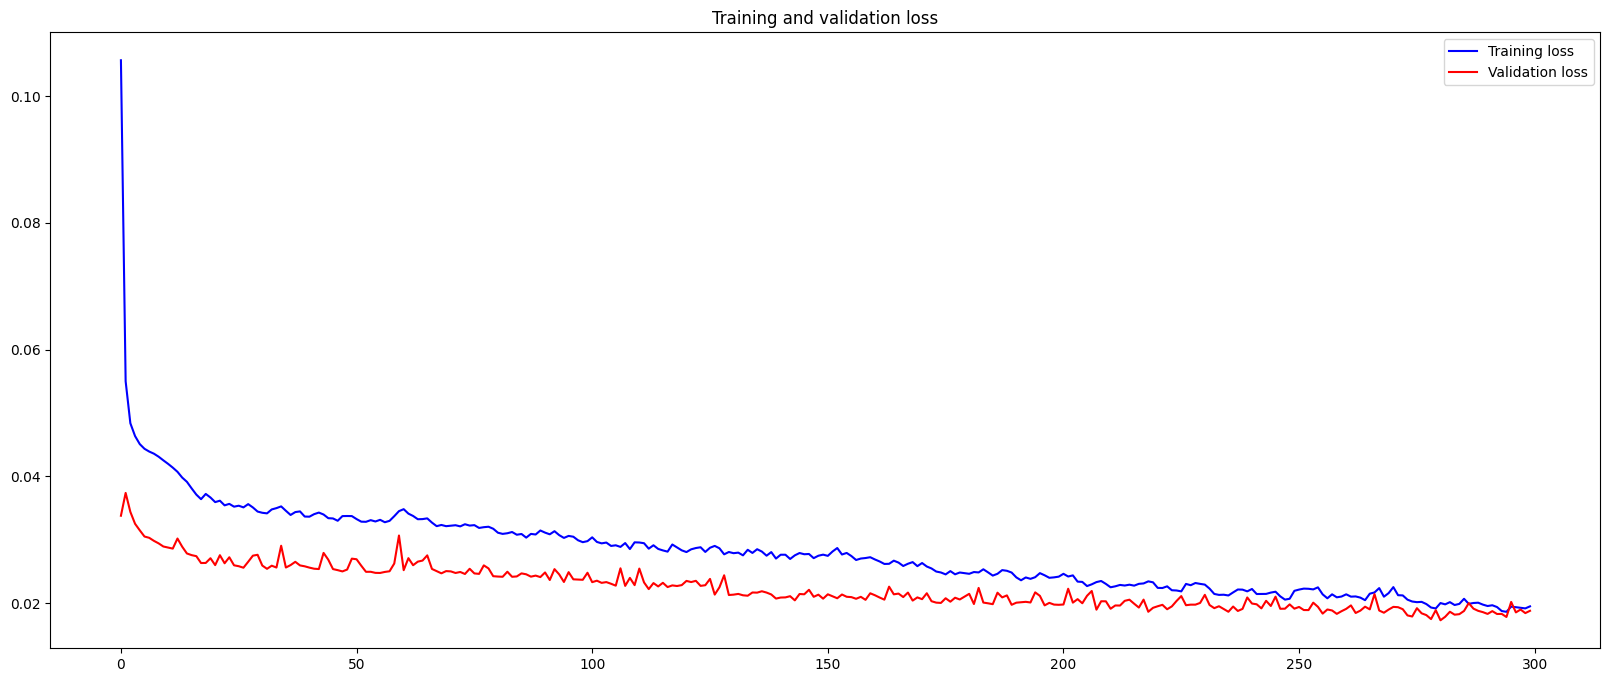

In [22]:
plot_loss(history_conv_lstm)

In [23]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step 


{'mae': np.float32(0.017590007),
 'mse': np.float32(0.0004758876),
 'r2': 0.7292567491531372}

#### Plot predictions

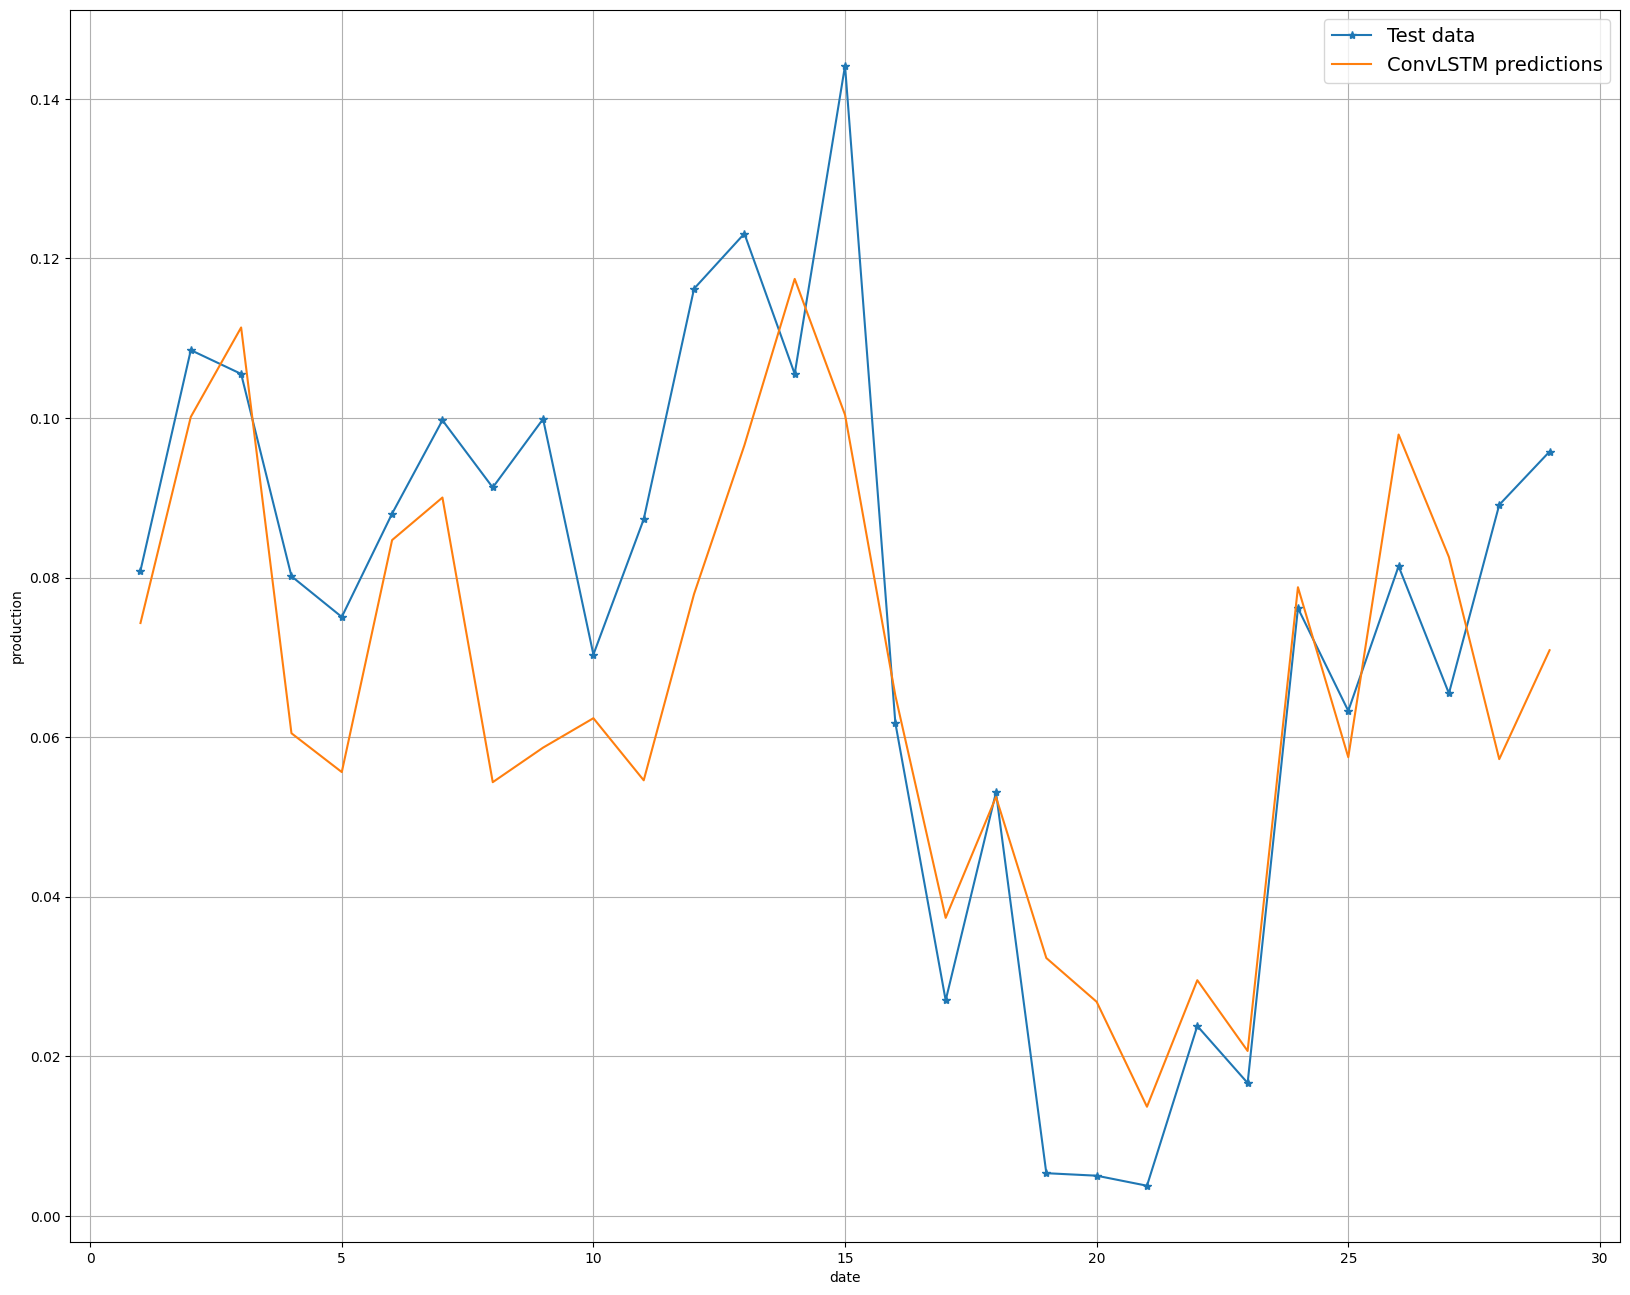

In [24]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)

In [25]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Définition de la fonction objective pour Optuna
def objective(trial):
    # Suggestions d'hyperparamètres
    filters1 = trial.suggest_categorical('filters1', [16, 32, 64, 96, 128])
    filters2 = trial.suggest_categorical('filters2', [16, 32, 64, 96, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [1])  # Fixé à 1
    activation1 = trial.suggest_categorical('activation1', ['relu', 'tanh'])
    activation2 = trial.suggest_categorical('activation2', ['relu', 'tanh'])
    dense_units = trial.suggest_categorical('dense_units', [32, 64, 96, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.008)
    
    # Construction du modèle avec ces hyperparamètres
    model = Sequential([
        ConvLSTM1D(filters=filters1, kernel_size=(kernel_size,), activation=activation1,
                   return_sequences=True, input_shape=x_train_conv_lstm.shape[1:]),
        ConvLSTM1D(filters=filters2, kernel_size=(kernel_size,), activation=activation2, return_sequences=False),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(1, activation="linear")
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')
    
    # Entraînement rapide pour l'optimisation
    model.fit(x_train_conv_lstm, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(x_val_conv_lstm, y_val))
    score = model.evaluate(x_val_conv_lstm, y_val, verbose=0)
    return score

# Lancer l'étude Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Affichage des meilleurs hyperparamètres trouvés
print("Best hyperparameters:", study.best_params)


[I 2025-04-02 21:59:14,012] A new study created in memory with name: no-name-6fe28669-73ff-45ed-b676-d85b48498d66
C:\Users\yhoci\AppData\Local\Temp\ipykernel_11388\1573941806.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.008)
C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-04-02 21:59:56,838] Trial 0 finished with value: 0.02756192348897457 and parameters: {'filters1': 32, 'filters2': 128, 'kernel_size': 1, 'activation1': 'tanh', 'activation2': 'tanh', 'dense_units': 96, 'learning_rate': 0.0016966109742499486}. B

Best hyperparameters: {'filters1': 64, 'filters2': 16, 'kernel_size': 1, 'activation1': 'relu', 'activation2': 'tanh', 'dense_units': 64, 'learning_rate': 0.0013603946616864242}
